In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
sns.set_style("ticks")

# Additional Imports
import pickle
from sklearn.linear_model import LogisticRegression

# Preprocessing

In [2]:
df = pd.read_csv("data/purchase_data.csv")
scaler = pickle.load(open('models/scaler.pickle', 'rb'))
pca = pickle.load(open('models/pca.pickle', 'rb'))
km_pca = pickle.load(open('models/kmeans_pca.pickle', 'rb'))

In [3]:
features = df[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_std = scaler.transform(features)
df_pca = pca.transform(df_std)
segments = km_pca.predict(df_pca)

In [4]:
df_pa = pd.concat([df, pd.get_dummies(segments, prefix='Segment')], axis=1)
df_pa

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,47,1,110866,1,0,1,0,0,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,47,1,110866,1,0,1,0,0,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,47,1,110866,1,0,1,0,0,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,47,1,110866,1,0,1,0,0,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,47,1,110866,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58688,200000500,703,0,0,0,2,1,1.41,1.85,2.01,...,0,42,1,120946,1,0,1,0,0,0
58689,200000500,710,0,0,0,0,0,1.36,1.84,2.09,...,0,42,1,120946,1,0,1,0,0,0
58690,200000500,717,0,0,0,0,0,1.50,1.80,2.14,...,0,42,1,120946,1,0,1,0,0,0
58691,200000500,722,1,2,3,0,0,1.51,1.82,2.09,...,0,42,1,120946,1,0,1,0,0,0


# Modelling
## First Model: Incidence by Average Price of Product

In [5]:
y = df_pa.Incidence
X = pd.DataFrame()
X['mean_price'] = (df_pa.Price_1 + df_pa.Price_2 + df_pa.Price_3 + df_pa.Price_4 + df_pa.Price_5)/5

In [6]:
model_purchase = LogisticRegression()
model_purchase.fit(X, y)
model_purchase.coef_

array([[-2.3480548]])

## Price Elasticity for Purchase Probability

In [7]:
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


The minimum overall price is \$1.10, the maximum overall price is \$2.80.

In [8]:
df_price_range = pd.DataFrame(np.arange(0.5, 2.81, 0.01), columns=['price'])

Text(0.5, 1.0, 'Purchase Probability per Price')

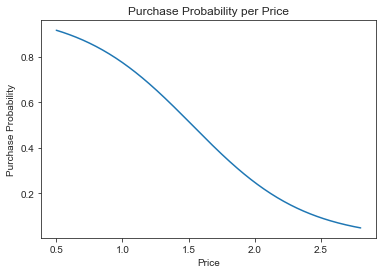

In [9]:
y_pr = model_purchase.predict_proba(df_price_range)[:,1]
sns.lineplot(df_price_range.values[:, 0], y_pr, ci=None)
plt.xlabel("Price")
plt.ylabel("Purchase Probability")
plt.title("Purchase Probability per Price")

The simplefied formula for price elasticity is:  
$E = \beta_0 \cdot price \cdot (1-\mathbb{P}(purchase))$  where $\beta_0$ is the coefficient from the model.

In [10]:
pe = model_purchase.coef_[:, 0] * df_price_range.values[:, 0] * (1-y_pr)

In [11]:
df_price_range['mean_pe'] = pe
df_price_range['purchase_proba'] = y_pr


Text(0.5, 1.0, 'Elasticity per Price')

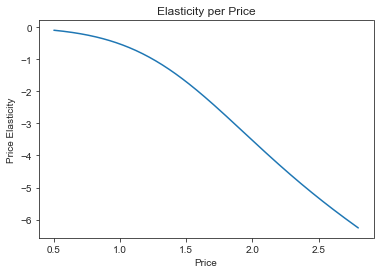

In [12]:
sns.lineplot(data = df_price_range, x='price', y='mean_pe')
plt.xlabel("Price")
plt.ylabel("Price Elasticity")
plt.title("Elasticity per Price")

## Purchase Probability by Segments

In [13]:
# Career-Focused <=> 3
df_pa_3 = df_pa.query('Segment_3 == 1')
y = df_pa_3.Incidence
X = pd.DataFrame()
X['mean_price'] = (df_pa_3.Price_1 + df_pa_3.Price_2 + df_pa_3.Price_3 + df_pa_3.Price_4 + df_pa_3.Price_5)/5

In [14]:
model_purchase_seg3 = LogisticRegression()
model_purchase_seg3.fit(X, y)
model_purchase_seg3.coef_

array([[-1.24578907]])

In [15]:
y_pr = model_purchase_seg3.predict_proba(df_price_range[['price']])[:, 1]
pe = model_purchase_seg3.coef_[:, 0] * df_price_range['price'] * (1-y_pr)
df_price_range['mean_pe_seg3'] = pe
df_price_range['purchase_proba_seg3'] = y_pr

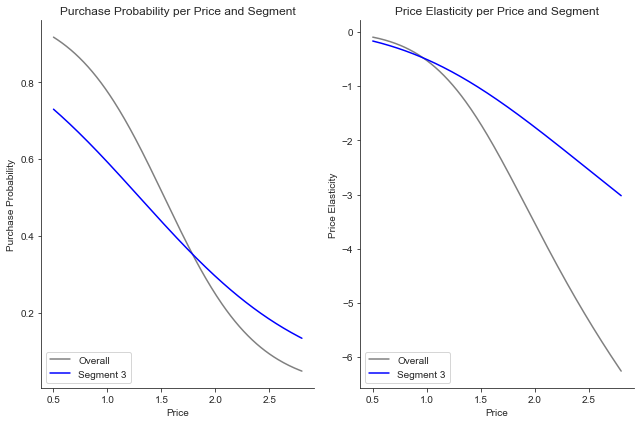

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(9,6))

sns.lineplot(data=df_price_range, x='price', y='purchase_proba', label='Overall', ax=axes[0], color='grey')
sns.lineplot(data=df_price_range, x='price', y='purchase_proba_seg3', label='Segment 3', ax=axes[0], color='blue')
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Purchase Probability")
axes[0].set_title("Purchase Probability per Price and Segment")
axes[0].legend(loc=3)

sns.lineplot(data=df_price_range, x='price', y='mean_pe', label='Overall', ax=axes[1], color='grey')
sns.lineplot(data=df_price_range, x='price', y='mean_pe_seg3', label='Segment 3', ax=axes[1], color='b')
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Price Elasticity")
axes[1].set_title("Price Elasticity per Price and Segment")
axes[1].legend(loc=3)

sns.despine()
plt.tight_layout()

# Purchase Probability with Promotion

In [19]:
y = df_pa.Incidence
X = pd.DataFrame()
X['mean_price'] = (df_pa.Price_1 + df_pa.Price_2 + df_pa.Price_3 + df_pa.Price_4 + df_pa.Price_5)/5
X['mean_promotion'] = (df_pa.Promotion_1 + df_pa.Promotion_2 + df_pa.Promotion_3 + df_pa.Promotion_4 + df_pa.Promotion_5)/5
X.head()

,mean_price,mean_promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


In [20]:
model_incidence_promotion = LogisticRegression()
model_incidence_promotion.fit(X, y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
pd.DataFrame(model_incidence_promotion.coef_[0], index=X.columns, columns=['slope'])

,slope
mean_price,-1.494026
mean_promotion,0.561525


# Modelling Brand Choice

In [38]:
# Select all Purchases
df_bc = df_pa.query('Incidence == 1').copy()

In [40]:
y = df_bc.Brand
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = df_bc[features]

In [73]:
# Sklearn LogisticRegression automatically support Multinomial Logistic Regression
model_brand_choice = LogisticRegression()
model_brand_choice.fit(X, y)
bc_coefs = pd.DataFrame(np.round(model_brand_choice.coef_, 2), index=[f"{z[0]}_{z[1]}" for z in zip(["Brand"]*5, np.sort(df_bc.Brand.unique()))], columns=features).T
bc_coefs

,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
Price_1,-3.94,1.24,1.61,0.59,0.50
Price_2,0.71,-1.84,0.34,0.44,0.34
Price_3,2.14,0.22,-1.28,-0.71,-0.38
Price_4,0.55,-0.14,0.64,-0.97,-0.09
Price_5,-0.40,0.90,-0.12,0.54,-0.92


## Determining Optimal Pricing for Brand 5

In [116]:
price_range = np.arange(0.5, 2.81, 0.01)
df_own_brand = pd.DataFrame(price_range, columns=['Price_5'])
for p in features[:-1]:
    df_own_brand[p] = df_bc[p].mean()
df_own_brand.head()

,Price_5,Price_1,Price_2,Price_3,Price_4
0,0.50,1.384559,1.764717,2.006694,2.159658
1,0.51,1.384559,1.764717,2.006694,2.159658
2,0.52,1.384559,1.764717,2.006694,2.159658
3,0.53,1.384559,1.764717,2.006694,2.159658
4,0.54,1.384559,1.764717,2.006694,2.159658


In [105]:
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand)[:, -1]
df_own_brand['brand_5_purchase_proba'] = predict_brand_5
df_own_brand

,Price_5,Price_1,Price_2,Price_3,Price_4,brand_5_purchase_proba
0,0.50,1.384559,1.764717,2.006694,2.159658,0.171081
1,0.51,1.384559,1.764717,2.006694,2.159658,0.176358
2,0.52,1.384559,1.764717,2.006694,2.159658,0.181713
3,0.53,1.384559,1.764717,2.006694,2.159658,0.187143
4,0.54,1.384559,1.764717,2.006694,2.159658,0.192643
...,...,...,...,...,...,...
226,2.76,1.384559,1.764717,2.006694,2.159658,0.254827
227,2.77,1.384559,1.764717,2.006694,2.159658,0.253454
228,2.78,1.384559,1.764717,2.006694,2.159658,0.252085
229,2.79,1.384559,1.764717,2.006694,2.159658,0.250720


In [119]:
beta5 = bc_coefs.iloc[4,4]
own_pe_brand_5 = beta5 * price_range * (1-predict_brand_5)
df_own_brand['brand_5_pe'] = own_pe_brand_5
df_own_brand

,Price_5,Price_1,Price_2,Price_3,Price_4,brand_5_pe
0,0.50,1.384559,1.764717,2.006694,2.159658,-0.381303
1,0.51,1.384559,1.764717,2.006694,2.159658,-0.386453
2,0.52,1.384559,1.764717,2.006694,2.159658,-0.391469
3,0.53,1.384559,1.764717,2.006694,2.159658,-0.396349
4,0.54,1.384559,1.764717,2.006694,2.159658,-0.401095
...,...,...,...,...,...,...
226,2.76,1.384559,1.764717,2.006694,2.159658,-1.892144
227,2.77,1.384559,1.764717,2.006694,2.159658,-1.902497
228,2.78,1.384559,1.764717,2.006694,2.159658,-1.912867
229,2.79,1.384559,1.764717,2.006694,2.159658,-1.923253


Text(0.5, 1.0, 'Own Price Elasticity of Purchase Probability for Brand 5')

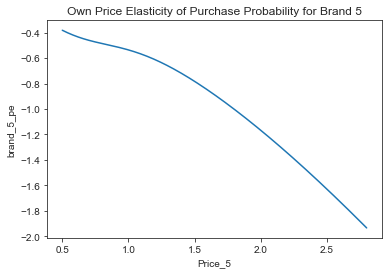

In [120]:
sns.lineplot(data = df_own_brand, x='Price_5', y='brand_5_pe')
plt.title("Own Price Elasticity of Purchase Probability for Brand 5")

## Cross Price Elasticity Brand 5 and Brand 4

In [130]:
df_xpe = pd.DataFrame(price_range, columns=['Price_4'])
for p in features:
    if p != 'Price_4':
        df_xpe[p] = df_bc[p].mean()
df_xpe.head()

,Price_4,Price_1,Price_2,Price_3,Price_5
0,0.50,1.384559,1.764717,2.006694,2.654296
1,0.51,1.384559,1.764717,2.006694,2.654296
2,0.52,1.384559,1.764717,2.006694,2.654296
3,0.53,1.384559,1.764717,2.006694,2.654296
4,0.54,1.384559,1.764717,2.006694,2.654296


In [131]:
pred_b5_b4_xpe = model_brand_choice.predict_proba(df_xpe)

Formula for Cross Price Elasticity:  
$XPE = -\beta_{ownPrice} * price_{crossBrand}*\mathbb{P}(crossBrand)$

In [132]:
proba_brand_4 = pred_b5_b4_xpe[:, 3]
xpe = -beta5 * price_range * proba_brand_4
df_xpe['b5Xb4_pe'] = xpe

Text(0.5, 1.0, 'Cross Price Elasticity of Brand 5 with respect to Brand 4')

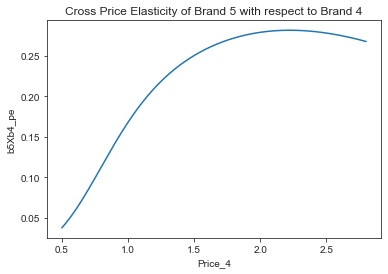

In [134]:
sns.lineplot(data=df_xpe, x='Price_4', y='b5Xb4_pe')
plt.title("Cross Price Elasticity of Brand 5 with respect to Brand 4")